# Term Deposit Subscription Prediction


### - Sai Venkata Manoj Vungarala
### - Ishal Abhishek Mummidivarapu
### - Ramya Kondrakunta

## 1. Data Pre-processing

In [2]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 414 kB/s 


In [3]:
!pip install imbalanced-learn

In [4]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report,accuracy_score, log_loss,precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Reading the csv file
df = pd.read_csv("bank-full.csv",sep=';')

In [6]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [7]:
# Checking for null values
df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [8]:
# Replacing yes with 1 and no with 0
df.y = df.y.eq('yes').mul(1)
df.default = df.default.eq('yes').mul(1)
df.housing = df.housing.eq('yes').mul(1)
df.loan = df.loan.eq('yes').mul(1)

## 2. Ordinal Encoding

In [9]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['contact'],return_df=True,
                           mapping=[{'col':'contact',
'mapping':{'cellular':2, 'telephone':0, 'unknown':1}}])

In [10]:
df[['contact']] = encoder.fit_transform(df[['contact']])

In [11]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['month'],return_df=True,
                           mapping=[{'col':'month',
'mapping':{'apr':9, 'aug':11, 'dec':1, 'feb':7, 'jan':2, 'jul':10, 'jun':8, 'mar':3, 'may':12,
       'nov':6, 'oct':5, 'sep':4}}])

In [12]:
df[['month']] = encoder.fit_transform(df[['month']])

In [13]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['job'],return_df=True,
                           mapping=[{'col':'job',
'mapping':{'unemployed':0,'unknown':1,'student':2,'housemaid':3,'blue-collar':4,'technician':5,'services':6,
           'retired':7,'admin':8,'self-employed':9,'entrepreneur':10,'management':11}}])

In [14]:
df[['job']] = encoder.fit_transform(df[['job']])

In [15]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['marital'],return_df=True,
                           mapping=[{'col':'marital',
'mapping':{'single':0,'divorced':1,'married':2}}])

In [16]:
df[['marital']] = encoder.fit_transform(df[['marital']])

In [17]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['education'],return_df=True,
                           mapping=[{'col':'education',
'mapping':{'unknown':0,'primary':1,'secondary':2,'tertiary':3}}])

In [18]:
df[['education']] = encoder.fit_transform(df[['education']])

In [19]:
# Using Ordinal Encoding to convert categorical columns
encoder= ce.OrdinalEncoder(cols=['poutcome'],return_df=True,
                           mapping=[{'col':'poutcome',
'mapping':{'failure':0,'other':1,'unknown':2,'success':3}}])

In [20]:
df[['poutcome']] = encoder.fit_transform(df[['poutcome']])

In [21]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,11.0,2,3,0,2143,1,0,1,5,12,261,1,-1,0,2,0
1,44,5.0,0,2,0,29,1,0,1,5,12,151,1,-1,0,2,0
2,33,10.0,2,2,0,2,1,1,1,5,12,76,1,-1,0,2,0
3,47,4.0,2,0,0,1506,1,0,1,5,12,92,1,-1,0,2,0
4,33,1.0,0,0,0,1,0,0,1,5,12,198,1,-1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,5.0,2,3,0,825,0,0,2,17,6,977,3,-1,0,2,1
45207,71,7.0,1,1,0,1729,0,0,2,17,6,456,2,-1,0,2,1
45208,72,7.0,2,2,0,5715,0,0,2,17,6,1127,5,184,3,3,1
45209,57,4.0,2,2,0,668,0,0,0,17,6,508,4,-1,0,2,0


## 3. Correlation and Heat Map

In [22]:
# Finding the correlation
df.corr()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.078259,0.376104,-0.173615,-0.017879,0.097783,-0.185513,-0.015655,-0.122114,-0.009120,-0.086378,-0.004648,0.004760,-0.023758,0.001288,0.020678,0.025155
job,0.078259,1.000000,0.035643,0.376480,0.008913,0.067506,-0.063879,-0.015011,0.064248,0.022594,-0.027862,0.003221,0.023540,-0.023232,0.006032,0.007397,0.016835
marital,0.376104,0.035643,1.000000,-0.137510,-0.009584,0.020602,0.020202,0.046738,-0.058796,0.007701,0.022085,-0.022895,0.029121,-0.029490,-0.015676,0.007471,-0.065668
education,-0.173615,0.376480,-0.137510,1.000000,-0.009035,0.050572,-0.038689,0.004307,0.156922,0.021661,-0.046916,0.002554,0.000194,0.007092,0.025295,-0.009235,0.051341
default,-0.017879,0.008913,-0.009584,-0.009035,1.000000,-0.066745,-0.006025,0.077234,-0.000961,0.009424,0.015682,-0.010021,0.016822,-0.029979,-0.018329,0.022274,-0.022419
balance,0.097783,0.067506,0.020602,0.050572,-0.066745,1.000000,-0.068768,-0.084350,-0.002844,0.004503,-0.093798,0.021560,-0.014578,0.003435,0.016674,-0.004008,0.052838
housing,-0.185513,-0.063879,0.020202,-0.038689,-0.006025,-0.068768,1.000000,0.041323,-0.089783,-0.027982,0.244022,0.005075,-0.023599,0.124178,0.037076,-0.134047,-0.139173
loan,-0.015655,-0.015011,0.046738,0.004307,0.077234,-0.084350,0.041323,1.000000,0.015964,0.011370,0.014244,-0.012412,0.009980,-0.022754,-0.011043,-0.009605,-0.068185
contact,-0.122114,0.064248,-0.058796,0.156922,-0.000961,-0.002844,-0.089783,0.015964,1.000000,0.006302,-0.118184,0.029350,-0.046971,0.170654,0.091911,-0.142421,0.100822
day,-0.009120,0.022594,0.007701,0.021661,0.009424,0.004503,-0.027982,0.011370,0.006302,1.000000,-0.043602,-0.030206,0.162490,-0.093044,-0.051710,0.064721,-0.028348


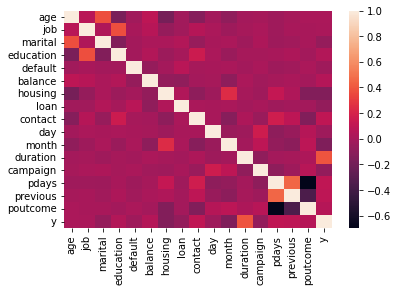

In [23]:
# Displaying the Heat Map
sns.heatmap(df.corr())

## 4. Training and Testing the Data

In [24]:
# training the dataset
X = df.drop("y", axis=1)
y = df["y"]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Implimenting different models
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    GaussianNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X,y)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X)
        acc = accuracy_score(y, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
        print("precision_score: \n",precision_score(y, train_predictions))
        print("f1_score: \n",f1_score(y, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y, train_predictions))
        print("log_loss: \n",log_loss(y, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
precision_score: 
 1.0
f1_score: 
 1.0
confusion_matrix: 
 [[31970     0]
 [    0  4198]]
log_loss: 
 9.992007221626413e-16
RandomForestClassifier
****Results****
Accuracy: 100.0000%
precision_score: 
 1.0
f1_score: 
 1.0
confusion_matrix: 
 [[31970     0]
 [    0  4198]]
log_loss: 
 9.992007221626413e-16
GradientBoostingClassifier
****Results****
Accuracy: 90.8344%
precision_score: 
 0.6769539078156313
f1_score: 
 0.5047064096817571
confusion_matrix: 
 [[31164   806]
 [ 2509  1689]]
log_loss: 
 3.1656903402084073
LogisticRegression
****Results****
Accuracy: 88.8907%
precision_score: 
 0.5669642857142857
f1_score: 
 0.2749909779862865
confusion_matrix: 
 [[31388   582]
 [ 3436   762]]
log_loss: 
 3.8370180524346247
GaussianNB
****Results****
Accuracy: 85.7222%
precision_score: 
 0.39242761692650335
f1_score: 
 0.4056169429097606
confusion_matrix: 
 [[29242  2728]
 [ 2436  1762]]
log_loss: 
 4.931442783817418


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


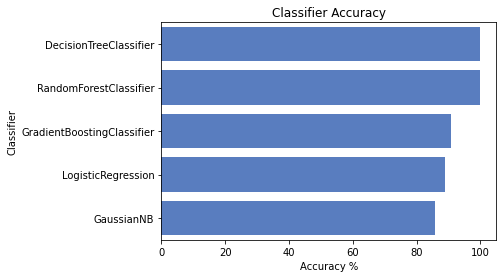

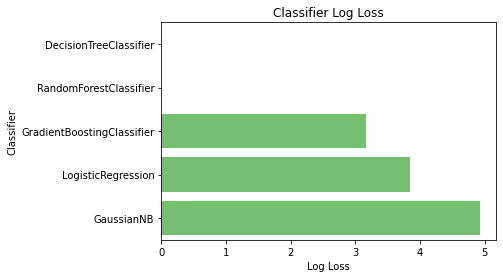

In [ ]:
# Comparison between Classifier Accuracy and Accuracy Percentage 
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [ ]:
# Implimenting different models
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    GaussianNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X,y)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
        print("precision_score: \n",precision_score(y_test, train_predictions))
        print("f1_score: \n",f1_score(y_test, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y_test, train_predictions))
        print("log_loss: \n",log_loss(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 85.4473%
precision_score: 
 0.40425531914893614
f1_score: 
 0.41924095322153576
confusion_matrix: 
 [[7252  700]
 [ 616  475]]
log_loss: 
 5.026383882992768
RandomForestClassifier
****Results****
Accuracy: 89.5499%
precision_score: 
 0.6126543209876543
f1_score: 
 0.4565842438182864
confusion_matrix: 
 [[7701  251]
 [ 694  397]]
log_loss: 
 3.6093491531732362
GradientBoostingClassifier
****Results****
Accuracy: 89.7047%
precision_score: 
 0.621580547112462
f1_score: 
 0.46769582618639227
confusion_matrix: 
 [[7703  249]
 [ 682  409]]
log_loss: 
 3.5558774658212946
LogisticRegression
****Results****
Accuracy: 88.5768%
precision_score: 
 0.5814606741573034
f1_score: 
 0.286109191430546
confusion_matrix: 
 [[7803  149]
 [ 884  207]]
log_loss: 
 3.9454467716421364
GaussianNB
****Results****
Accuracy: 85.1266%
precision_score: 
 0.39327731092436974
f1_score: 
 0.4103463393248575
confusion_matrix: 
 [[7230  722]
 [ 623  468]]
log_loss: 
 5.137

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Under sampling

In [25]:
from imblearn.under_sampling import NearMiss
from collections import Counter
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X_train, y_train = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 4198, 1: 4198})


## Under sampled metrics

In [ ]:
# Implimenting different models
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    GaussianNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_train)
        acc = accuracy_score(y_train, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
        print("precision_score: \n",precision_score(y_train, train_predictions))
        print("f1_score: \n",f1_score(y_train, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y_train, train_predictions))
        print("log_loss: \n",log_loss(y_train, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y_train, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
precision_score: 
 1.0
f1_score: 
 1.0
confusion_matrix: 
 [[4198    0]
 [   0 4198]]
log_loss: 
 9.992007221626413e-16
RandomForestClassifier
****Results****
Accuracy: 99.9881%
precision_score: 
 1.0
f1_score: 
 0.9998808814770698
confusion_matrix: 
 [[4198    0]
 [   1 4197]]
log_loss: 
 0.0041137180079703515
AdaBoostClassifier
****Results****
Accuracy: 91.3173%
precision_score: 
 0.9305038471084637
f1_score: 
 0.9113893278230218
confusion_matrix: 
 [[3918  280]
 [ 449 3749]]
log_loss: 
 2.998927093755401
GradientBoostingClassifier
****Results****
Accuracy: 92.4369%
precision_score: 
 0.9395509499136442
f1_score: 
 0.9230396315598111
confusion_matrix: 
 [[3953  245]
 [ 390 3808]]
log_loss: 
 2.612234267763064
LogisticRegression
****Results****
Accuracy: 88.5541%
precision_score: 
 0.919626652838994
f1_score: 
 0.8806952203600248
confusion_matrix: 
 [[3888  310]
 [ 651 3547]]
log_loss: 
 3.9533125286699056
GaussianNB
****Resul

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


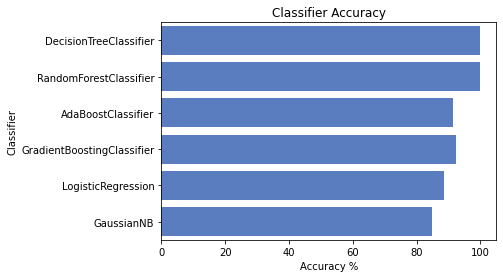

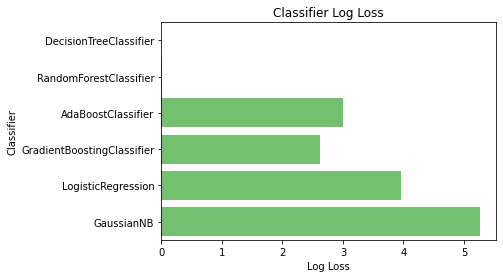

In [ ]:
# Comparison between Classifier Accuracy and Accuracy Percentage 
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [ ]:
# Implimenting different models
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    GaussianNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
        print("precision_score: \n",precision_score(y_test, train_predictions))
        print("f1_score: \n",f1_score(y_test, train_predictions))
        print("confusion_matrix: \n",confusion_matrix(y_test, train_predictions))
        print("log_loss: \n",log_loss(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100, log_loss(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 43.5696%
precision_score: 
 0.16319677635997312
f1_score: 
 0.2758620689655172
confusion_matrix: 
 [[2968 4984]
 [ 119  972]]
log_loss: 
 19.490806274114927
RandomForestClassifier
****Results****
Accuracy: 50.1714%
precision_score: 
 0.1845556992425642
f1_score: 
 0.30719557195571956
confusion_matrix: 
 [[3538 4414]
 [  92  999]]
log_loss: 
 17.210577889917555
AdaBoostClassifier
****Results****
Accuracy: 44.5759%
precision_score: 
 0.16743002544529262
f1_score: 
 0.282565130260521
confusion_matrix: 
 [[3044 4908]
 [ 104  987]]
log_loss: 
 19.14323473576023
GradientBoostingClassifier
****Results****
Accuracy: 46.5111%
precision_score: 
 0.17380703587600138
f1_score: 
 0.29211181033221134
confusion_matrix: 
 [[3208 4744]
 [  93  998]]
log_loss: 
 18.474826353244698
LogisticRegression
****Results****
Accuracy: 56.5078%
precision_score: 
 0.19906819144430327
f1_score: 
 0.32341303973851715
confusion_matrix: 
 [[4170 3782]
 [ 151  940]]
log_l

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Hyperparameter Tuning

### 1. Decision Tree

In [ ]:
param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range (1,10),
    "min_samples_split":range (1,10),
    "min_samples_leaf":range (1,5)
}

In [ ]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=param_dict,
                    cv = 5 ,
                    verbose = 1 ,
                    scoring = 'f1',
                    n_jobs=-1)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462
 0.71724462 0.71724462 0.71724462        nan 0.71724462 0.71724462
 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462
        nan 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462
 0.71724462 0.71724462 0.71724462        nan 0.71724462 0.71724462
 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462 0.71724462
        nan 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311
 0.73631311 0.73631311 0.73631311        nan 0.73631311 0.73631311
 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311
        nan 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311
 0.73631311 0.73631311 0.73631311        nan 0.73631311 0.73631311
 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311 0.73631311
        nan 0.78155773 0.78155773 0.78155773 0.781557

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [ ]:
print('Best Params: ', grid_search.best_params_)

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
print('Best Score: ', grid_search.best_score_)

0.8286966731898238

In [ ]:
def met(model,X_train1,y_train1,X_test1,y_test1):
  model.fit(X_train1,y_train1)

  print('................Train .......................')

  y_train_pred=model.predict(X_train1)
  print(confusion_matrix(y_train1, y_train_pred), ": is the confusion matrix")
  print(accuracy_score(y_train1, y_train_pred), ": is the accuracy score")
  print(precision_score(y_train1, y_train_pred), ": is the precision score")
  print(f1_score(y_train1, y_train_pred), ": is the f1 score")
  print(roc_auc_score(y_train1, y_train_pred), ": is the roc auc score")
  print(log_loss(y_train1, y_train_pred), ": is the logloss")

  print('................Test.......................')

  y_pred=model.predict(X_test1)
  print(confusion_matrix(y_test1, y_pred), ": is the confusion matrix")
  print(accuracy_score(y_test1, y_pred), ": is the accuracy score")
  print(precision_score(y_test1, y_pred), ": is the precision score")
  print(f1_score(y_test1, y_pred), ": is the f1 score")
  print(roc_auc_score(y_test1, y_pred), ": is the roc auc score")
  print(log_loss(y_test1, y_pred), ": is the logloss")

In [ ]:
model = DecisionTreeClassifier(criterion = 'gini',
                               max_depth = 9,
                               min_samples_leaf = 1,
                               min_samples_split = 2)

In [ ]:
met(model,X_train,y_train,X_test,y_test)

................Train .......................
[[25899  6115]
 [ 4179 27682]] : is the confusion matrix
0.8388414872798434 : is the accuracy score
0.8190667810752433 : is the precision score
0.8432178866246307 : is the f1 score
0.8389131627696225 : is the roc auc score
5.566294383522447 : is the logloss
................Test.......................
[[6292 1616]
 [1074 6987]] : is the confusion matrix
0.8315486254618323 : is the accuracy score
0.8121585493432524 : is the precision score
0.8385741718674988 : is the f1 score
0.8312079423229438 : is the roc auc score
5.818185274704549 : is the logloss


### 2. Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,15],
    'max_features': [3],
    'min_samples_leaf': [3,4,5,6],
    'min_samples_split': [3,4,5,6],
    'n_estimators': [1150, 1200, 1250, 1300,1350]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring = 'f1',
                           n_jobs = -1, 
                           verbose = 1)

In [ ]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 15],
                         'max_features': [3], 'min_samples_leaf': [3, 4, 5, 6],
                         'min_samples_split': [3, 4, 5, 6],
                         'n_estimators': [1150, 1200, 1250, 1300, 1350]},
             verbose=1)

In [ ]:
print('Best Score: ', grid_search.best_score_)

Best Score:  0.8943091976516634


In [ ]:
print('Best Params: ', grid_search.best_params_)

Best Params:  {'bootstrap': True, 'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1150}


In [ ]:
rfc = RandomForestClassifier(bootstrap = True,
                               max_depth = 15,
                               max_features = 4, 
                               min_samples_leaf = 4, 
                               min_samples_split = 4, 
                               n_estimators = 1300)

In [ ]:
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

In [ ]:
met(rfc,X_train,y_train,X_test,y_test)

................Train .......................
[[28735  3279]
 [ 2640 29221]] : is the confusion matrix
0.907334637964775 : is the accuracy score
0.8991076923076923 : is the precision score
0.9080343686393934 : is the f1 score
0.9073580688419627 : is the roc auc score
3.2005892659326807 : is the logloss
................Test.......................
[[6750 1158]
 [ 813 7248]] : is the confusion matrix
0.876573360886718 : is the accuracy score
0.8622412562455389 : is the precision score
0.8803060666788123 : is the f1 score
0.8763550179501935 : is the roc auc score
4.2630630727154575 : is the logloss


### 3. Logistic Regression

In [ ]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']
param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)
grid = GridSearchCV(estimator=LogisticRegression(),
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1)

In [ ]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [ ]:
print('Best Score: ', grid_result.best_score_)

Best Score:  0.8090444190553614


In [ ]:
print('Best Params: ', grid_result.best_params_)

Best Params:  {'C': 0.01, 'class_weight': {1: 0.6, 0: 0.4}, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
model = LogisticRegression(C=10,class_weight={1: 0.7, 0: 0.3},penalty='l1',solver='liblinear')

In [ ]:
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
met(model,X_train,y_train,X_test,y_test)

................Train .......................
[[20373 11641]
 [ 2678 29183]] : is the confusion matrix
0.7758277886497065 : is the accuracy score
0.7148491083676269 : is the precision score
0.802999243310174 : is the f1 score
0.7761626156004412 : is the roc auc score
7.7427796056737535 : is the logloss
................Test.......................
[[4946 2962]
 [ 670 7391]] : is the confusion matrix
0.7725593337090613 : is the accuracy score
0.713899352844586 : is the precision score
0.8027587705007061 : is the f1 score
0.771163175551217 : is the roc auc score
7.8556706289626055 : is the logloss


### 4. XGboost

In [ ]:
from xgboost import XGBClassifier
estimator = XGBClassifier(
    objective= 'binary:logistic',
    njob = -1,
    cv = 5,
    scoring = 'f1',
    seed=42
)

In [ ]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    verbose=True
)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print('Best Score: ', grid_result.best_score_)

In [ ]:
print('Best Params: ', grid_result.best_params_)

In [ ]:
grid_search.best_estimator_

In [ ]:
model = XGBClassifier(cv=5, max_depth=4, n_estimators=180, njob=-1, scoring='roc_auc',
              seed=42)
model.fit(X_train, y_train)

In [ ]:
met(model,X_train1,y_train1,X_test1,y_test1)

### 5. Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(estimator=GaussianNB(),
                            param_grid=param_grid_nb, 
                            scoring = 'f1',
                            verbose=1, 
                            cv=5, 
                            n_jobs=-1)

In [ ]:
nbModel_grid.fit(X_train, y_train)

In [ ]:
print(nbModel_grid.best_estimator_)

In [ ]:
print('Best Score: ', nbModel_grid.best_score_)

In [ ]:
print('Best Params: ', nbModel_grid.best_params_)

In [ ]:
model = GaussianNB(var_smoothing=0.002848035868435802)

In [ ]:
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
met(model,X_train,y_train,X_test,y_test)

## Hyperparameter Metrics :


In [26]:
print(y_train.shape)
print(y_test.shape)

# Implimenting different models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

classifiers = [
    DecisionTreeClassifier(criterion = 'gini',
                               max_depth = 9,
                               min_samples_leaf = 1,class_weight={1: 0.7, 0: 0.3},
                               min_samples_split = 2),
    RandomForestClassifier(bootstrap = True,
                               max_depth = 15,
                               max_features = 4,class_weight={1: 0.7, 0: 0.3}, 
                               min_samples_leaf = 4, 
                               min_samples_split = 4, 
                               n_estimators = 1300),
    XGBClassifier(cv=5, max_depth=4, n_estimators=180, njob=-1, scoring='roc_auc',
              seed=42),
    LogisticRegression(C=10,class_weight={1: 0.7, 0: 0.3},penalty='l1',solver='liblinear'),
    GaussianNB(var_smoothing=0.002848035868435802)]


# Logging for Visual Comparison
log_cols=["Classifier", "ROC"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print("-"*30)
        train_predictions = clf.predict(X_train)
        print("ROC AUC:\t",roc_auc_score(y_train, train_predictions))
        log_entry = pd.DataFrame([[name, roc_auc_score(y_train, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

(8396,)
(9043,)
DecisionTreeClassifier
------------------------------
ROC AUC:	 0.9318723201524536
RandomForestClassifier
------------------------------
ROC AUC:	 0.9549785612196283
XGBClassifier
------------------------------
ROC AUC:	 0.9465221534063841
LogisticRegression
------------------------------
ROC AUC:	 0.8841114816579324
GaussianNB
------------------------------
ROC AUC:	 0.7984754645069081


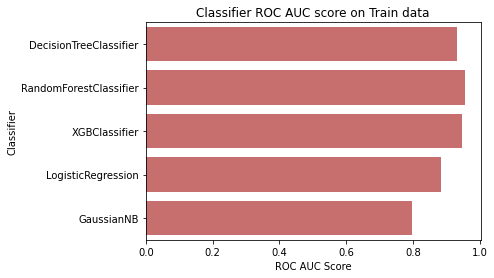

In [27]:
# Ploting ROC AUC on train data
sns.set_color_codes("muted")
sns.barplot(x='ROC', y='Classifier', data=log, color="r")

plt.xlabel('ROC AUC Score')
plt.title('Classifier ROC AUC score on Train data')
plt.show()


In [28]:
# Implimenting different models
classifiers = [
    DecisionTreeClassifier(criterion = 'gini',
                               max_depth = 9,
                               min_samples_leaf = 1,class_weight={1: 0.7, 0: 0.3},
                               min_samples_split = 2),
    RandomForestClassifier(bootstrap = True,
                               max_depth = 15,
                               max_features = 4, 
                               min_samples_leaf = 4, 
                               min_samples_split = 4,class_weight={1: 0.7, 0: 0.3}, 
                               n_estimators = 1300),
    XGBClassifier(cv=5, max_depth=4, n_estimators=180, njob=-1, scoring='roc_auc',
              seed=42),
    LogisticRegression(C=10,class_weight={1: 0.7, 0: 0.3},penalty='l1',solver='liblinear'),
    GaussianNB(var_smoothing=0.002848035868435802)]

# Logging for Visual Comparison
log_cols=["Classifier", "ROC"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print("-"*30)
        train_predictions = clf.predict(X_test)
        print("ROC AUC:\t",roc_auc_score(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, roc_auc_score(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

DecisionTreeClassifier
------------------------------
ROC AUC:	 0.6663475928900626
RandomForestClassifier
------------------------------
ROC AUC:	 0.7044117938612426
XGBClassifier
------------------------------
ROC AUC:	 0.6895674574486332
LogisticRegression
------------------------------
ROC AUC:	 0.7026472538254274
GaussianNB
------------------------------
ROC AUC:	 0.6341992721682985


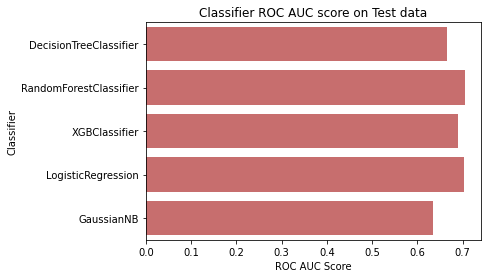

In [29]:
# Ploting ROC AUC on test data
sns.set_color_codes("muted")
sns.barplot(x='ROC', y='Classifier', data=log, color="r")

plt.xlabel('ROC AUC Score')
plt.title('Classifier ROC AUC score on Test data')
plt.show()